In [48]:
import sys
sys.path.append('..')

# Multiclass classification

## Learning objectives
- Understand how classification can be implemented when there are more than 2 classes
- Implement a multiclass classifier from scratch

## Intro - Binary classification vs multiclass classification

In binary classification the output must be either true or false. Either the example falls into this class, or it doesn't. We have seen that we can represent this by our model having a single output node whose value is forced between 0 and 1, and as such represents a confidence in the fact that the example belongs to the positive class. Alternatively, still for binary classification, we could have two output nodes, where the value of the first represents the confidence that the input belongs to the positive class (true/class 1) and the value of the second represents the confidence that the input belongs to the negative class (false/class 2). In this case, the values of each output node must be positive and they must sum to 1, because this output layer represents a probability distribution over the output classes. 

# Softmax

![](./images/binary-class.jpg)

In the case where we have two nodes to represent true and false, we can think about it as having trained two models.

Treating true and false as separate classes with separate output nodes shows us how we can extend this idea to do multiclass classification; we simply add more nodes and ensure that their values are positive and sum to one.

![](./images/multiclass.jpg)

### What function can we use to convert the output layer into a distribution over classes?

The **softmax function** exponentiates each value in a vector to make it positive and then divides each of them by their sum to normalise them (make them sum to 1). This ensures that the vector then can be interpreted as a probability distribution.

![](./images/softmax.jpg)

Example

![](./images/softmax_example.jpg)

## Differentiating the softmax

![](images/softmax_deriv.jpg)

### Properties of softmax
- increasing the value of any entry decreases the value of all of the others, because the whole vector must always sum to one. 
- an increase in one input element increases it's corresponding output element exponentially whilst pushing others down, this means that it is easy for the one largest output element to become the only one not close to zero. 

### What does the name "softmax" mean?
- as explained above, it's easy for only one input to be near 1, and all others close to zero. That is, the max input becomes the only non-zero element. So in this case, the softmax basically set all elements but the max to zero.
- the output of the max element of a vector changes abruptly when one element becomes larger than the current max. It suffers a "hard" change. Unlike this, the softmax function changes gradually when the max changes - we call this a "soft" change as it is continuous.

Let's implement our own softmax function, and again include a boolean flag that will return the gradient.

In [63]:
import numpy as np

def softmax(Z, labels=None, grad=False):
    """Z is a tensor of inputs to the softmax layer. It should have size BxK"""
    # print('z:', z.shape)
    if grad:
        num_classes = ## get number of classes

        gs = []
        S = softmax(Z)
        for example_idx, (z, y) in enumerate(zip(Z, labels)): # for each example, label pair
            g = ## init an empty grid of gradients for this example
            for i in range(num_classes): # for each output
                for j in range(num_classes): # for each input
                    if j != y: continue # this line is a hack that makes the dLdz not equal zero
                    if j == i: # if computing gradient of an element of the output with respect to the corresponding input
                        # print(softmax(Z))
                        g[i][j] = ## compute gradient 
                    else: # if computing gradient of an element of the output with respect to an input corresponding to a different output
                        g[i][j] = ## compute gradient of this element with respect to a different input
            gs.append(g) # add this matrix of gradients to the list of them for each example
        gs = np.array(gs) # array of matrix gradients (BxKxK)
        return gs # return array of gradient matrices

    s = ## compute softmax and make sure that it is the right shape
    return s

z = np.random.rand(2, 3) # m x k # examples, m = 2, n_classes, k = 3
print(z)
print(softmax(z))
print('softmax sums up to:', np.sum(softmax(z), axis=1))
print()
print('gradient:')
print(softmax(z, labels=[2, 0], grad=True))

[[0.40568846 0.23320483 0.63039378]
 [0.66171156 0.04090049 0.75859057]]
[[0.32325575 0.27204301 0.40470124]
 [0.37889762 0.20366062 0.41744176]]
softmax sums up to: [1. 1.]

gradient:
[[[ 0.          0.         -0.130822  ]
  [ 0.          0.         -0.11009614]
  [ 0.          0.          0.24091815]]

 [[ 0.23533421  0.          0.        ]
  [-0.07716652  0.          0.        ]
  [-0.15816769  0.          0.        ]]]


## The cross entropy loss function

In the BCE loss function, the one line equation contained all of the "switches" that it needs to turn on or off certain terms of the equation.
This was possible because in binary classification, the labels will certainly either be 0 or 1.

In multiclass classification however, these switches cannot be contained in a single line.

An appropriate loss function to use for multiclass classification is the cross entropy loss function.
Like BCE loss, cross entropy uses the same term: the negative natural log of the output probability to penalise outputs exponentially as they stray from the ground truth.

We don't need to simultaneously push down the incorrect class probabilities and push up the correct class probabilities.
This is because by increasing the value of one element of the output of a softmax, the others must decrease, because the whole vector has to sum to 1.
So if we focus on increasing the correct class likelihood element, then we will implicitly be decreasing the incorrect class likelihood elements.

![](images/cross_entropy_loss.jpg)

Let's implement the cross entropy loss function.

In [50]:
def CrossEntropyLoss(predictions, labels=None, grad=False):
    if grad:
        correct_label_prediction = ## get the log probability of the prediction for the correct label
        return ## compute derivative
    return ## return cross entropy loss

test = np.random.rand(2, 3)
print(test)
labels = [0, 1]
print('cross entropy loss:')
print(CrossEntropyLoss(test))
print()
print('cross entropy loss gradient:')
CrossEntropyLoss(test, labels, grad=True)

[[0.05376548 0.21236135 0.37105373]
 [0.80713144 0.89658858 0.03280428]]
cross entropy loss:
1.5341035236425185

cross entropy loss gradient:


array([-18.59929355,  -1.11533876])

## Calculating the parameter update rule

Let's loook at the gradient computation for multiclass classification on the whiteboard

## Multiclass classification implementation from scratch

Other than the final layer of the model where the softmax is applied and the loss function, the model and algorithm stay the same. 

Of course however, changing the model changes the gradient of the loss function with respect to the model parameters.
So we'll need to change the code that performs the parameter updates.



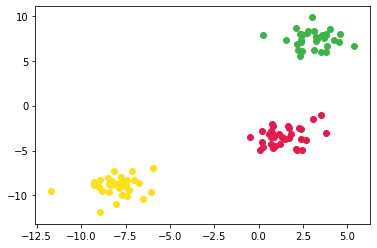

In [55]:
from utils import get_classification_data, show_data

num_classes=3

X, Y = get_classification_data(sd=1, m=100, n_clusters=num_classes)
X.shape
show_data(X, Y)

In [56]:
import matplotlib.pyplot as plt

class Classifier:
    def __init__(self, n_features, n_classes):
        self.w = np.random.rand(n_features, n_classes)
        self.b = np.random.rand(n_classes)
        self.n_classes = n_classes
        self.n_features = n_features
    
    def __call__(self, X):
        X = np.matmul(X, self.w) + self.b # make linear prediction
        X = ## apply softmax
        return X

    def update_params(self, new_w, new_b):
        self.w = new_w
        self.b = new_b    

    def calc_deriv(self, X, predictions, labels):
        m = len(X) # m = number of examples

        dzdb = np.ones((self.n_classes, 1)) 
        dzdw = X

        dhdz = ## get rate of change of predictions (softmax output) wrt softmax input
        dhdz = np.expand_dims(dhdz, axis=1) # expand dims so that still 2d when we loop over the batch dim
        
        # print('dzdw:', dzdw.shape)
        dzdw = np.expand_dims(dzdw, axis=1) # add extra dimension to expand
        dzdw = np.repeat(dzdw, self.n_classes, axis=1)#x is the deriv for all z, so repeat here, so that dims match (distribute)
        # print('dzdw:', dzdw.shape)

        # dhdz \in Bx1xK
        # dzdw \in BxKxN
        # print('m:', m)
        dhdw = ## for each example, do a matrix multiplication to get the gradient
        dhdb = ## dzdb is same scalar (1) for all examples so no fancy matrix tricks
        # print('dhdb:', dhdb.shape)

        # REMOVE EXTRA DIMS
        dhdw = np.squeeze(dhdw)
        dhdb = np.squeeze(dhdb)

        return dhdw, dhdb

# TEST OUR CLASS WORKS
H = Classifier(2, 3) # test init works
print(X.shape) # m x n
p = H(X) # test predict works
dhdw, dhdb = H.calc_deriv(X, p, Y) # test calc derivs works
print('dhdw:', dhdw.shape)
print('dhdb:', dhdb.shape)

(100, 2)
dhdw: (100, 3, 2)
dhdb: (100, 3)


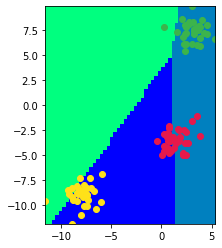

In [59]:
from utils import visualise_predictions

H = Classifier(n_features=2, n_classes=3)

def H_vis(X):
    """Returns predictions in the correct format for our visualiser function"""
    return np.argmax(H(X), axis=1)

visualise_predictions(H_vis, X, Y) # visualise predictions before training

2.1283787569880372


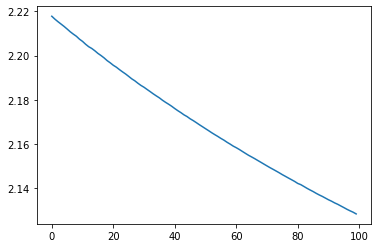

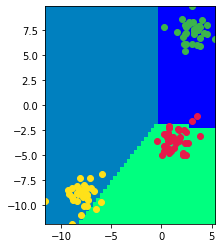

In [62]:
learning_rate = 0.000001
from random import shuffle

H = Classifier(n_features=2, n_classes=3) # initialise classifier

def batch_examples(X, Y, batch_size=4):
    """Group examples into batches"""

    # SHUFFLE X AND Y IN SAME ORDER
    zipped = list(zip(X, Y)) # pair features and labels together
    shuffle(zipped) # shuffle zipped list
    X, Y = zip(*zipped) # unpack now zipped features and labels

    # BATCH EXAMPLES
    idx = 0
    m = len(X)
    batches = []
    while idx < m:
        if idx + batch_size <= m: # if this batch finishes before we reach the end of the dataset
            x = X[idx: idx + batch_size]
            y = Y[idx: idx + batch_size]
        else: # if this batch tries to index beyond the length of the dataset
            x = X[idx:]
            y = Y[idx:]
        batches.append((x, y))
        idx += batch_size
    return batches

# TRAINING LOOP
epochs = 100
losses = [] # list of losses to plot
for epoch in range(epochs): # for e epochs
    epoch_losses = [] # init empty list of losses for this batch

    for x, y in batch_examples(X, Y): # for each batch
        b = len(x) # get length of batch
        prediction = ## make predictions
        loss = ## compute loss
        # print('loss:',loss)
        epoch_losses.append(loss) # append loss for this batch to list of losses for this epoch
        dhdw, dhdb = H.calc_deriv(x, prediction, y) # calculate rate of change of hypothesis wrt model params

        dLdh = ## compute gradient of cross entropy loss

        dLdw = ## for each example, combine the derivs with the chain rule
        dLdw = ## average over batches
        dLdw = ## transpose to match shape of weights

        dLdb = ## chain rule 
        dLdb = ## take the mean loss acros the batch dimension (average gradient over examples)
        new_w = H.w - learning_rate * dLdw # parameter update
        new_b = H.b - learning_rate * dLdb # parameter update
        H.update_params(new_w, new_b) # update parameters
    losses.append(np.mean(epoch_losses)) # add mean of losses over epocch
        
# print(losses)
print(losses[-1]) # print final loss
plt.plot(losses)
plt.show()
visualise_predictions(H_vis, X, Y)

## Summary
- multiclass classification requires a different loss function 
- softmax is a differentiable function that turns a vector of real numbers into a probability distribution

## Challenges
- Plot class probability landscape for each class over 2d feature space, with vertical height representing probability of being a member of each class